In [71]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import requests
import shapely

In [72]:

# Cases dataset
cases_url = "https://data.sfgov.org/resource/tpyr-dvnc.csv"   # ARCHIVED COVID-19 Cases by Geography

cases = pd.read_csv(cases_url)
cases = pd.DataFrame(cases)

cases.head(), cases.shape

(               area_type                     id  acs_population    count  \
 0  Analysis Neighborhood  Bayview Hunters Point           38480  15013.0   
 1  Analysis Neighborhood         Bernal Heights           26149   5861.0   
 2  Analysis Neighborhood    Castro/Upper Market           23138   4072.0   
 3  Analysis Neighborhood              Chinatown           14310   2482.0   
 4  Analysis Neighborhood              Excelsior           40980  11252.0   
 
    count_last_60_days         rate  deaths max_specimen_collection_date  \
 0               170.0  3901.507277    84.0      2023-09-06T00:00:00.000   
 1                80.0  2241.385904    31.0      2023-09-06T00:00:00.000   
 2                64.0  1759.875529    23.0      2023-09-06T00:00:00.000   
 3                29.0  1734.451433    60.0      2023-09-06T00:00:00.000   
 4               120.0  2745.729624    97.0      2023-09-06T00:00:00.000   
 
                 data_as_of           data_loaded_at  \
 0  2023-09-11T04:30:0

In [73]:
# Testing locations
testing_url = "https://data.sfgov.org/resource/dtit-7gp4.csv"

testing = pd.DataFrame(pd.read_csv(testing_url))

# Vaccine access points
vax_url = "https://data.sfgov.org/resource/bw5r-gd57.csv"

vax = pd.DataFrame(pd.read_csv(vax_url))

In [74]:
### initial data exploration
cases.head()
testing.head()
vax.head()

cases.info()
testing.info()
vax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   area_type                     310 non-null    object 
 1   id                            310 non-null    object 
 2   acs_population                310 non-null    int64  
 3   count                         299 non-null    float64
 4   count_last_60_days            299 non-null    float64
 5   rate                          299 non-null    float64
 6   deaths                        109 non-null    float64
 7   max_specimen_collection_date  310 non-null    object 
 8   data_as_of                    310 non-null    object 
 9   data_loaded_at                310 non-null    object 
 10  multipolygon                  309 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 26.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 t

In [75]:
cases['area_type'].value_counts()

,count
area_type,
Census Tract,241
Analysis Neighborhood,41
ZCTA,27
Citywide,1


In [76]:
# Keep only analysis neighborhood rows from cases
cases_nb = cases[cases['area_type'] == 'Analysis Neighborhood'].copy()

# Treat 'id' as neighborhood name
cases_nb = cases_nb.rename(columns={'id': 'neighborhood'})

# Keep only useful columns
cases_nb = cases_nb[[
    'neighborhood',
    'acs_population',
    'count',
    'rate',
    'deaths',
    'multipolygon'
]]



# Convert multipolygon WKT string into geometry
cases_nb['geometry'] = gpd.GeoSeries.from_wkt(cases_nb['multipolygon'])


cases_gdf = gpd.GeoDataFrame(
    cases_nb,
    geometry='geometry',
    crs="EPSG:4326"
)

cases_gdf.head(), cases_gdf.shape

(            neighborhood  acs_population    count         rate  deaths  \
 0  Bayview Hunters Point           38480  15013.0  3901.507277    84.0   
 1         Bernal Heights           26149   5861.0  2241.385904    31.0   
 2    Castro/Upper Market           23138   4072.0  1759.875529    23.0   
 3              Chinatown           14310   2482.0  1734.451433    60.0   
 4              Excelsior           40980  11252.0  2745.729624    97.0   
 
                                         multipolygon  \
 0  MULTIPOLYGON (((-122.39356284899998 37.7084013...   
 1  MULTIPOLYGON (((-122.40361299982806 37.7493370...   
 2  MULTIPOLYGON (((-122.42655500055685 37.7694849...   
 3  MULTIPOLYGON (((-122.4062259995664 37.79755900...   
 4  MULTIPOLYGON (((-122.4249859998036 37.73156000...   
 
                                             geometry  
 0  MULTIPOLYGON (((-122.39356 37.7084, -122.3935 ...  
 1  MULTIPOLYGON (((-122.40361 37.74934, -122.4035...  
 2  MULTIPOLYGON (((-122.42656 37.76

In [77]:
# Top neighborhoods by case rate
top_rate = (
    cases_gdf[['neighborhood', 'rate', 'count']]
    .sort_values('rate', ascending=False)
)

top_rate.head(10)

,neighborhood,rate,count
0,Bayview Hunters Point,3901.507277,15013.0
27,Portola,2878.778551,4676.0
38,Visitacion Valley,2781.383648,5528.0
19,Mission Bay,2762.940735,3683.0
4,Excelsior,2745.729624,11252.0
35,Tenderloin,2652.560048,7885.0
18,Mission,2600.643571,15194.0
24,Outer Mission,2600.421975,6409.0
40,Western Addition,2515.359433,5609.0
28,Potrero Hill,2509.936005,3726.0


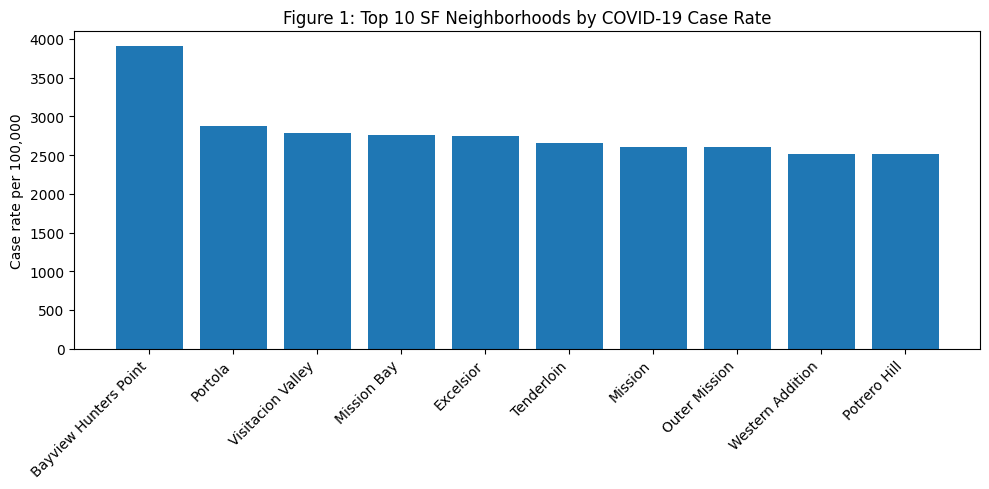

In [78]:
# Top 10 case rate bar graph
top10 = top_rate.head(10)

plt.figure(figsize=(10, 5))
plt.bar(top10['neighborhood'], top10['rate'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Case rate per 100,000')
plt.title('Figure 1: Top 10 SF Neighborhoods by COVID-19 Case Rate')
plt.tight_layout()
plt.show()

In [79]:
# GeoDataFrame for testing sites from 'point' WKT
testing['geometry'] = gpd.GeoSeries.from_wkt(testing['point'])

testing_gdf = gpd.GeoDataFrame(
    testing,
    geometry='geometry',
    crs="EPSG:4326"
)

# Spatial join with neighborhood polygons
testing_joined = gpd.sjoin(
    testing_gdf,
    cases_gdf[['neighborhood', 'geometry']],
    how='left',
    predicate='within'   # use 'intersects' if 'within' errors
)

# Count testing sites per neighborhood
testing_counts = (
    testing_joined
    .groupby('neighborhood')
    .size()
    .reset_index(name='testing_count').sort_values('testing_count', ascending= False)
)

testing_counts

,neighborhood,testing_count
3,Financial District/South Beach,2
0,Bayview Hunters Point,1
1,Castro/Upper Market,1
2,Chinatown,1
4,Hayes Valley,1
5,Inner Richmond,1
6,Inner Sunset,1
7,Japantown,1
8,McLaren Park,1
9,Mission,1


In [80]:
print(type(vax))
print(vax.columns.tolist())
print('data_analysis_neighborhood' in vax.columns)

<class 'pandas.core.frame.DataFrame'>
['site_name', 'parent_org', 'location_address', 'location_city', 'vaccine_provider', 'info_url', 'booking_url', 'booking_phone', 'dropins_allowed', 'language_served', 'remote_language_services', 'wheelchair_accessible', 'latitude', 'longitude', 'census_tract', 'data_anaylsis_neighborhood', 'zip_code', 'supevisor_district', 'shape', ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv', ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md', ':@computed_region_jwn9_ihcz']
False


In [81]:
vax_url = "https://data.sfgov.org/resource/bw5r-gd57.csv?$limit=50000"
vax_raw = pd.read_csv(vax_url)

vax_raw.columns

Index(['site_name', 'parent_org', 'location_address', 'location_city',
       'vaccine_provider', 'info_url', 'booking_url', 'booking_phone',
       'dropins_allowed', 'language_served', 'remote_language_services',
       'wheelchair_accessible', 'latitude', 'longitude', 'census_tract',
       'data_anaylsis_neighborhood', 'zip_code', 'supevisor_district', 'shape',
       ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv',
       ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md',
       ':@computed_region_jwn9_ihcz'],
      dtype='object')

In [82]:
vax_gdf = gpd.GeoDataFrame(
    vax_raw,
    geometry=gpd.points_from_xy(vax_raw['longitude'], vax_raw['latitude']),
    crs="EPSG:4326"
)

vax_gdf

,site_name,parent_org,location_address,location_city,vaccine_provider,info_url,booking_url,booking_phone,dropins_allowed,language_served,...,data_anaylsis_neighborhood,zip_code,supevisor_district,shape,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md,:@computed_region_jwn9_ihcz,geometry
0,Walgreens #1626,Walgreen Co.,2494 San Bruno Avenue,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,Portola,94134,9,POINT (-122.4048 37.73011),91,2,2,25,91,POINT (-122.4048 37.73011)
1,NEMS (San Bruno),NEMS,2574 San Bruno Avenue,San Francisco,SFDPH,www.nems.org,www.nems.org,415-391-9686,No,"English, Chinese",...,Portola,94134,9,POINT (-122.404495 37.72902),91,2,2,25,91,POINT (-122.4045 37.72902)
2,"AITC, Immunization and Travel Clinic",SFDPH,"101 Grove St, Room 102",San Francisco,SFDPH,https://www.sfcdcp.org/aitc/,https://booknow.appointment-plus.com/6sxvcsey/,415-554-2625,No,"English, Spanish, Chinese",...,Tenderloin,94102,5,POINT (-122.41866 37.77813),21,4,10,36,21,POINT (-122.41866 37.77813)
3,Walgreens #4609,Walgreen Co.,1301 Market Street,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,South of Market,94103,6,POINT (-122.416405 37.777134),32,5,10,34,32,POINT (-122.4164 37.77713)
4,CVS Store #05131,CVS,1900 19th Avenue,San Francisco,Federal,NaN,https://www.cvs.com/immunizations/covid-19-vac...,800-746-7287,Yes,NaN,...,Inner Sunset,94116,7,POINT (-122.47575 37.75211),44,10,8,14,44,POINT (-122.47575 37.75211)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Walgreens #15331,Walgreen Co.,500 Parnassus Ave.,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,Inner Sunset,94122,7,POINT (-122.45839 37.76388),110,7,11,14,110,POINT (-122.45839 37.76388)
103,Walgreens #1297,Walgreen Co.,670 4th Street,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,Mission Bay,94107,6,POINT (-122.393906 37.776543),34,1,10,4,34,POINT (-122.3939 37.77654)
104,Walgreens #6625,Walgreen Co.,2141 Chestnut St.,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,Marina,94123,2,POINT (-122.43852 37.800247),17,4,6,13,17,POINT (-122.43852 37.80025)
105,Walgreens #4231,Walgreen Co.,2690 Mission Street,San Francisco,Federal,NaN,https://www.walgreens.com/topic/promotion/covi...,NaN,No,NaN,...,Mission,94110,9,POINT (-122.41902 37.75403),53,3,2,20,53,POINT (-122.41902 37.75403)


In [83]:
# Make sure vaccine points and neighborhoods use the same CRS
vax_gdf = vax_gdf.to_crs(cases_gdf.crs)

# Spatial join to assign each vaccine site to a neighborhood polygon
vax_joined = gpd.sjoin(
    vax_gdf,
    cases_gdf[['neighborhood', 'geometry']],
    how='left',
    predicate='within'   # use 'intersects' if 'within' gives an error
)

vax_joined[['site_name', 'neighborhood']]

,site_name,neighborhood
0,Walgreens #1626,Portola
1,NEMS (San Bruno),Portola
2,"AITC, Immunization and Travel Clinic",Tenderloin
3,Walgreens #4609,South of Market
4,CVS Store #05131,Inner Sunset
...,...,...
102,Walgreens #15331,Inner Sunset
103,Walgreens #1297,Mission Bay
104,Walgreens #6625,Marina
105,Walgreens #4231,Mission


In [84]:
vax_counts = (
    vax_joined
    .groupby('neighborhood')
    .size()
    .reset_index(name='vax_count').sort_values('vax_count', ascending = False)
)

vax_counts

,neighborhood,vax_count
14,Mission,10
28,Sunset/Parkside,8
29,Tenderloin,7
5,Financial District/South Beach,6
32,West of Twin Peaks,6
25,Presidio Heights,5
15,Mission Bay,5
2,Castro/Upper Market,5
3,Chinatown,4
20,Outer Mission,4


In [85]:
summary = cases_gdf[['neighborhood', 'acs_population', 'count', 'rate', 'deaths']].copy()

summary = summary.merge(testing_counts, on='neighborhood', how='left')
summary = summary.merge(vax_counts, on='neighborhood', how='left')

summary['testing_count'] = summary['testing_count'].fillna(0).astype(int)
summary['vax_count'] = summary['vax_count'].fillna(0).astype(int)
summary['total_access'] = summary['testing_count'] + summary['vax_count']
summary['death_rate'] = (summary['deaths']/summary['acs_population']) *100000 # death rate per 100000 residents

summary = summary.sort_values('total_access', ascending = False)

summary.head()

,neighborhood,acs_population,count,rate,deaths,testing_count,vax_count,total_access,death_rate
18,Mission,58424,15194.0,2600.643571,86.0,1,10,11,147.199781
34,Sunset/Parkside,81639,13974.0,1711.681917,95.0,1,8,9,116.365953
35,Tenderloin,29726,7885.0,2652.560048,81.0,1,7,8,272.488730
5,Financial District/South Beach,22963,5176.0,2254.060881,12.0,2,6,8,52.257980
2,Castro/Upper Market,23138,4072.0,1759.875529,23.0,1,5,6,99.403579


In [86]:
summary.shape

(41, 9)

In [87]:
# Make sure we only use rows with both values present
q3_df = summary[['rate', 'total_access']].dropna()
# Correlation matrix
q3_corr = q3_df.corr()
q3_corr

,rate,total_access
rate,1.000000,0.183274
total_access,0.183274,1.000000


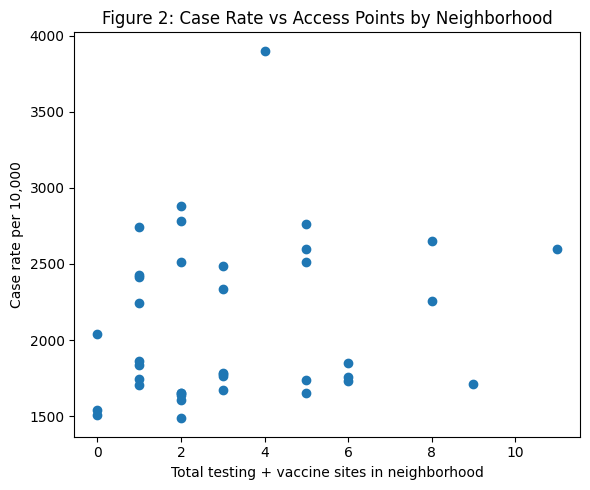

In [88]:
# Cases vs access by neighborhood scatterplot
plt.figure(figsize=(6, 5))
plt.scatter(q3_df['total_access'], q3_df['rate'])
plt.xlabel('Total testing + vaccine sites in neighborhood')
plt.ylabel('Case rate per 10,000')
plt.title('Figure 2: Case Rate vs Access Points by Neighborhood')
plt.tight_layout()
plt.show()

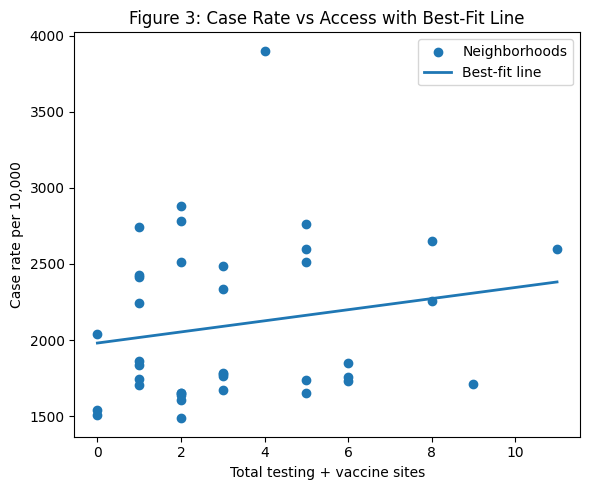

The slope is 36.503865160224166 and the case rate when there are 0 access is 1980.1804460081512.


In [89]:
# Adding a best fit line to the scatterplot

x = q3_df['total_access'].values
y = q3_df['rate'].values

# Fit a simple line: y = a*x + b
a, b = np.polyfit(x, y, 1)

plt.figure(figsize=(6, 5))
plt.scatter(x, y, label='Neighborhoods')
plt.plot(x, a*x + b, label='Best-fit line', linewidth=2)
plt.xlabel('Total testing + vaccine sites')
plt.ylabel('Case rate per 10,000')
plt.title('Figure 3: Case Rate vs Access with Best-Fit Line')
plt.legend()
plt.tight_layout()
plt.show()

print(f'The slope is {a} and the case rate when there are 0 access is {b}.')

In [90]:
# Death rate vs access correlation matrix
death_v_access = summary[['death_rate', 'total_access']].dropna()

death_v_access_corr = death_v_access.corr()
death_v_access_corr

,death_rate,total_access
death_rate,1.000000,-0.083617
total_access,-0.083617,1.000000


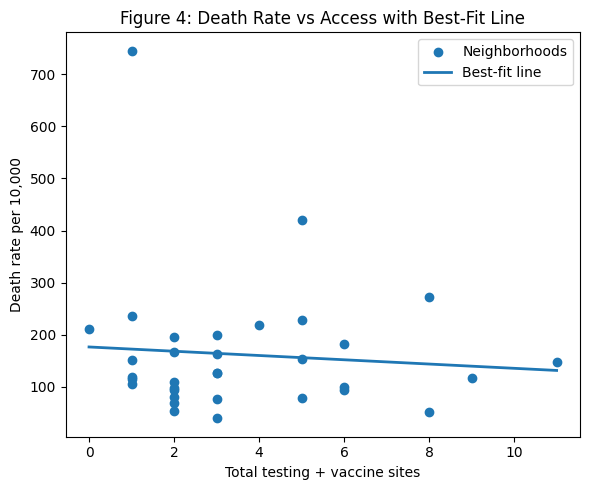

The slope is -4.095706565751768 and the death rate when there are 0 access is 176.653611021904.


In [91]:
# Death rate vs access scatterplot
x = death_v_access['total_access'].values
y = death_v_access['death_rate'].values

## line y=mx+k
m, k =np.polyfit(x,y,1)

plt.figure(figsize=(6, 5))
plt.scatter(x, y, label='Neighborhoods')
plt.plot(x, m*x + k, label='Best-fit line', linewidth=2)
plt.xlabel('Total testing + vaccine sites')
plt.ylabel('Death rate per 10,000')
plt.title('Figure 4: Death Rate vs Access with Best-Fit Line')
plt.legend()
plt.tight_layout()
plt.show()

print(f'The slope is {m} and the death rate when there are 0 access is {k}.')


In [92]:
# Thresholds for classification
rate_high = summary['rate'].quantile(0.75)          # 75th percentile of case rate
access_low = summary['total_access'].quantile(0.25) # 25th percentile of access

rate_high, access_low

(np.float64(2503.4730131138645), np.float64(1.0))

In [93]:
def classify_hotspot(row):
    if (row['rate'] >= rate_high) and (row['total_access'] <= access_low):
        return 'High cases, low access'
    elif (row['rate'] < rate_high) and (row['total_access'] >= access_low):
        return 'Low cases, High Access'
    elif (row['rate'] >= rate_high) and (row['total_access'] > access_low):
        return 'High cases, High Access'
    elif (row['rate'] <= rate_high) and (row['total_access'] <= access_low):
        return 'Low cases, Low access'
    else:
        return 'Other'

summary['hotspot_label'] = summary.apply(classify_hotspot, axis=1)

hotspot_cases = summary[['neighborhood', 'rate', 'total_access', 'hotspot_label']]
hotspot_cases

,neighborhood,rate,total_access,hotspot_label
18,Mission,2600.643571,11,"High cases, High Access"
34,Sunset/Parkside,1711.681917,9,"Low cases, High Access"
35,Tenderloin,2652.560048,8,"High cases, High Access"
5,Financial District/South Beach,2254.060881,8,"Low cases, High Access"
2,Castro/Upper Market,1759.875529,6,"Low cases, High Access"
30,Presidio Heights,1729.056965,6,"Low cases, High Access"
39,West of Twin Peaks,1851.630505,6,"Low cases, High Access"
19,Mission Bay,2762.940735,5,"High cases, High Access"
3,Chinatown,1734.451433,5,"Low cases, High Access"
25,Outer Richmond,1653.951252,5,"Low cases, High Access"


In [94]:
hotspots = (
    summary[summary['hotspot_label'] == 'High cases, low access']
    .sort_values('rate', ascending=False)
)

hotspots[['neighborhood', 'rate', 'testing_count', 'vax_count', 'total_access']]

,neighborhood,rate,testing_count,vax_count,total_access
4,Excelsior,2745.729624,0,1,1


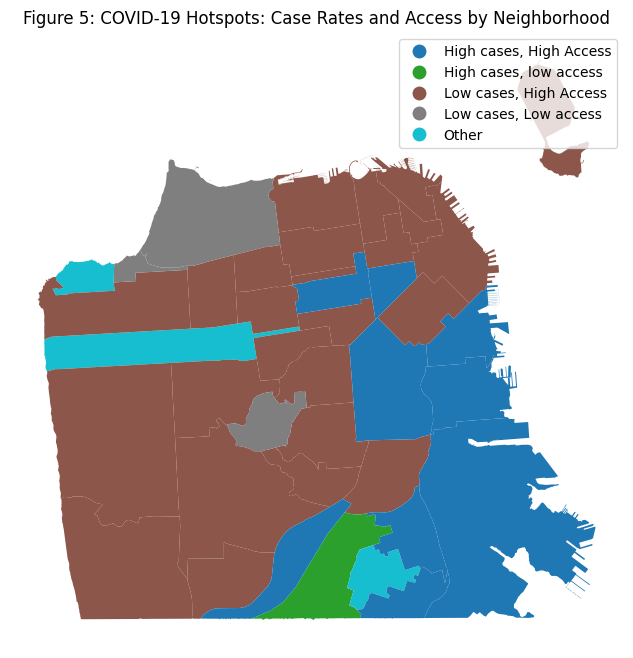

In [95]:
# Attach hotspot_label to the GeoDataFrame of neighborhoods
# The structure of this hotspot_label merge and plot was drafted with help from AI
cases_with_labels = cases_gdf.merge(
    hotspot_cases[['neighborhood', 'hotspot_label']],
    on='neighborhood',
    how='left'
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cases_with_labels.plot(column='hotspot_label', ax=ax, legend=True)
ax.set_title('Figure 5: COVID-19 Hotspots: Case Rates and Access by Neighborhood')
ax.axis('off')
plt.show()

In [96]:
# Thresholds for classification of deaths
death_rate_high = summary['death_rate'].quantile(0.75)          # 75th percentile of case rate
access_low = summary['total_access'].quantile(0.25) # 25th percentile of access

death_rate_high, access_low

(np.float64(196.22641509433961), np.float64(1.0))

In [97]:
def classify_hotspot_deaths(row):
    if (row['death_rate'] >= death_rate_high) and (row['total_access'] <= access_low):
        return 'High death rate, low access'
    elif (row['death_rate'] < death_rate_high) and (row['total_access'] >= access_low):
        return 'Low death rate, High Access'
    elif (row['death_rate'] >= death_rate_high) and (row['total_access'] > access_low):
        return 'High death rate, High Access'
    elif (row['death_rate'] <= death_rate_high) and (row['total_access'] <= access_low):
        return 'Low death rate, Low access'
    else:
        return 'Other'

summary['hotspot_label'] = summary.apply(classify_hotspot_deaths, axis=1)

hotspot_deaths = summary[['neighborhood', 'rate', 'total_access', 'hotspot_label']]
hotspot_deaths

,neighborhood,rate,total_access,hotspot_label
18,Mission,2600.643571,11,"Low death rate, High Access"
34,Sunset/Parkside,1711.681917,9,"Low death rate, High Access"
35,Tenderloin,2652.560048,8,"High death rate, High Access"
5,Financial District/South Beach,2254.060881,8,"Low death rate, High Access"
2,Castro/Upper Market,1759.875529,6,"Low death rate, High Access"
30,Presidio Heights,1729.056965,6,"Low death rate, High Access"
39,West of Twin Peaks,1851.630505,6,"Low death rate, High Access"
19,Mission Bay,2762.940735,5,Other
3,Chinatown,1734.451433,5,"High death rate, High Access"
25,Outer Richmond,1653.951252,5,"Low death rate, High Access"


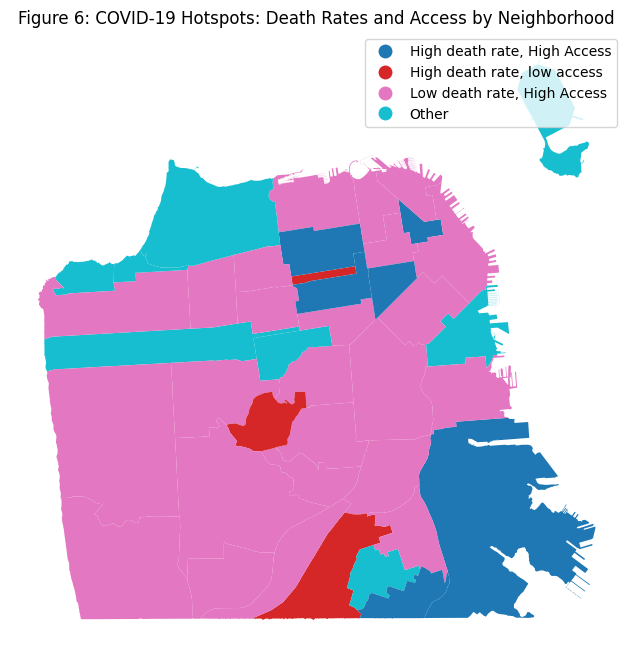

In [98]:
# Deaths hotspots map
# The structure of this hotspot_label merge and plot was drafted with help from AI


deaths_with_labels = cases_gdf.merge(
    hotspot_deaths[['neighborhood', 'hotspot_label']],
    on='neighborhood',
    how='left'
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
deaths_with_labels.plot(column='hotspot_label', ax=ax, legend=True)
ax.set_title('Figure 6: COVID-19 Hotspots: Death Rates and Access by Neighborhood')
ax.axis('off')
plt.show()

In [99]:
summary[['rate', 'total_access']].describe()

,rate,total_access
count,38.000000,41.000000
mean,2100.258950,3.073171
std,529.828138,2.677594
min,1485.244989,0.000000
25%,1706.920531,1.000000
50%,1842.900680,2.000000
75%,2503.473013,5.000000
max,3901.507277,11.000000


In [100]:
summary.isna().sum()

,0
neighborhood,0
acs_population,0
count,3
rate,3
deaths,8
testing_count,0
vax_count,0
total_access,0
death_rate,8
hotspot_label,0


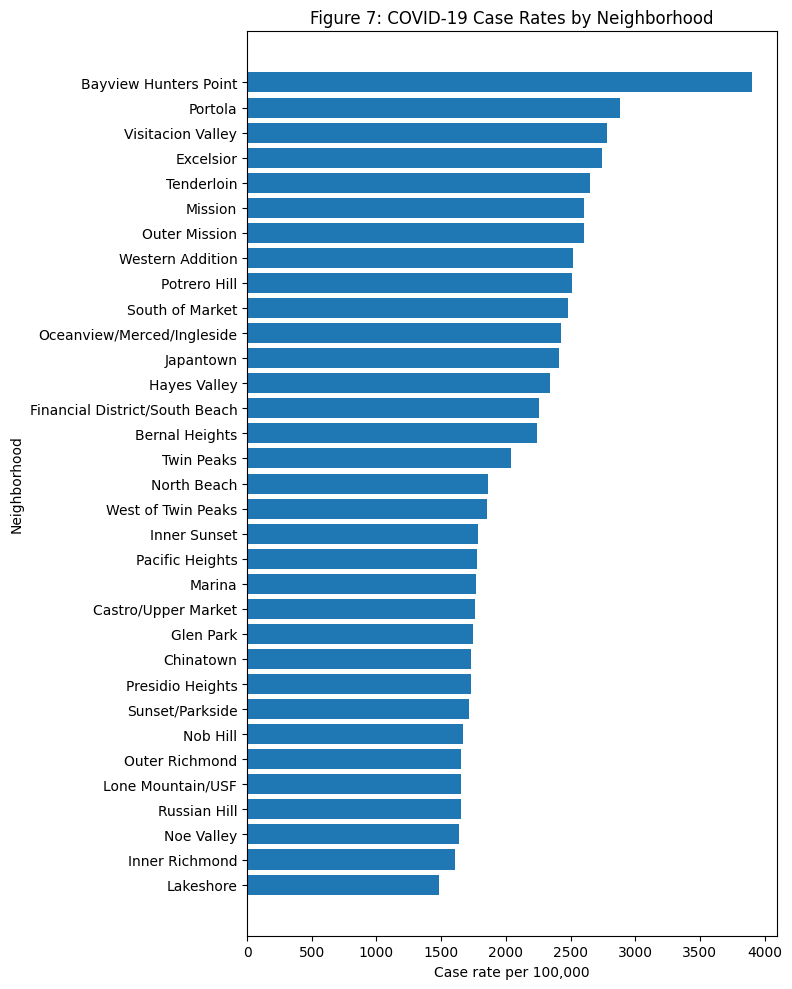

In [101]:
# Case rates by neighborhood
plt.figure(figsize=(8, 10))
all_sorted = summary.sort_values('rate').dropna()
plt.barh(all_sorted['neighborhood'], all_sorted['rate'])
plt.xlabel('Case rate per 100,000')
plt.ylabel('Neighborhood')
plt.title('Figure 7: COVID-19 Case Rates by Neighborhood')
plt.tight_layout()
plt.show()

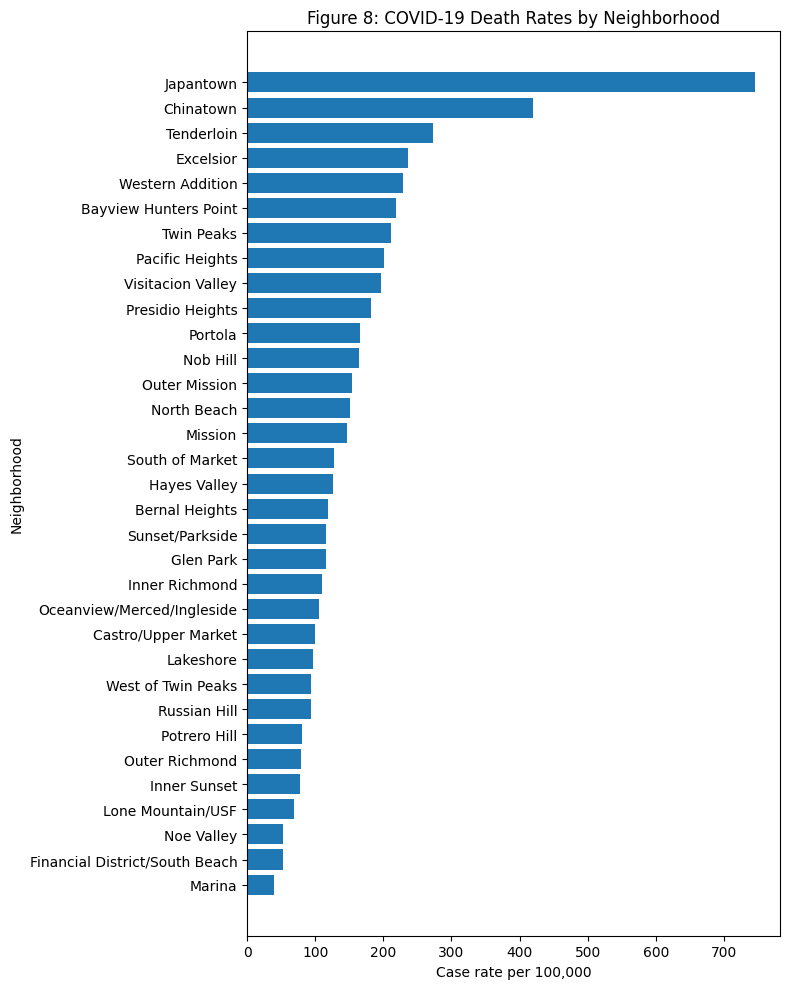

In [102]:
# Death rate by neighborhood

plt.figure(figsize=(8, 10))
all_sorted_deaths = summary.sort_values('death_rate').dropna()
plt.barh(all_sorted_deaths['neighborhood'], all_sorted_deaths['death_rate'])
plt.xlabel('Case rate per 100,000')
plt.ylabel('Neighborhood')
plt.title('Figure 8: COVID-19 Death Rates by Neighborhood')
plt.tight_layout()
plt.show()

In [103]:
import scipy.stats as sci


# since outliers exist, we use nonparametric correlation tests (use kendalls tau test since it is less sensitive to extreme data)

cleaned_summary = summary.dropna() # drop all NaNs


# Kendalls tau tests
tau_cases_stat, tau_cases_p = sci.kendalltau(cleaned_summary['total_access'], cleaned_summary['rate'], alternative = 'greater')[0],sci.kendalltau(cleaned_summary['total_access'], cleaned_summary['rate'], alternative = 'greater')[1]
print(f"The test statistic for the correlation between case rate and total access was {tau_cases_stat} and the p value is {tau_cases_p}")

tau_deaths_stat, tau_deaths_p = sci.kendalltau(cleaned_summary['total_access'], cleaned_summary['death_rate'], alternative = 'less')[0],sci.kendalltau(cleaned_summary['total_access'], cleaned_summary['death_rate'], alternative = 'less')
[1]

print(f"The test statistic for the correlation between death rate and total access was {tau_cases_stat} and the p value is {tau_cases_p}")



# Now kendall tau testing for numbers of testing stations individually

tau_cases_test_stat, tau_cases_test_p = sci.kendalltau(cleaned_summary['testing_count'], cleaned_summary['rate'], alternative = 'greater')[0],sci.kendalltau(cleaned_summary['testing_count'], cleaned_summary['rate'], alternative = 'greater')[1]
tau_deaths_test_stat, tau_deaths_test_p = sci.kendalltau(cleaned_summary['testing_count'], cleaned_summary['death_rate'], alternative = 'less')[0], sci.kendalltau(cleaned_summary['testing_count'], cleaned_summary['death_rate'], alternative = 'less')[1]

print(f"The test statistic for the correlation between case rate and testing station access was {tau_cases_test_stat} and the p value is {tau_cases_test_p}")
print(f"The test statistic for the correlation between death rate and testing station access was {tau_deaths_test_stat} and the p value is {tau_deaths_test_p}")

# Now kendall tau testing for numbers of vax stations individually

tau_cases_vax_stat, tau_cases_vax_p  = sci.kendalltau(cleaned_summary['vax_count'], cleaned_summary['rate'], alternative = 'greater')[0], sci.kendalltau(cleaned_summary['vax_count'], cleaned_summary['rate'], alternative = 'greater')[1]
tau_deaths_vax_stat,tau_deaths_vax_p  = sci.kendalltau(cleaned_summary['vax_count'], cleaned_summary['death_rate'], alternative = 'less')[0], sci.kendalltau(cleaned_summary['vax_count'], cleaned_summary['death_rate'], alternative = 'less')[1]


print(f"The test statistic for the correlation between case rate and vaccination station access was {tau_cases_vax_stat} and the p value is {tau_cases_vax_p}")
print(f"The test statistic for the correlation between death rate and vaccination station access was {tau_deaths_vax_stat} and the p value is {tau_deaths_vax_p}")


The test statistic for the correlation between case rate and total access was 0.040582062796472834 and the p value is 0.3763623993577768
The test statistic for the correlation between death rate and total access was 0.040582062796472834 and the p value is 0.3763623993577768
The test statistic for the correlation between case rate and testing station access was 0.1743796122207214 and the p value is 0.11388780712624114
The test statistic for the correlation between death rate and testing station access was 0.10770505460691614 and the p value is 0.7718488564937017
The test statistic for the correlation between case rate and vaccination station access was 0.0 and the p value is 0.5
The test statistic for the correlation between death rate and vaccination station access was -0.04464026907612011 and the p value is 0.364420335431793


In [104]:
import scipy

# Linear regression slope hypothesis testing for both case rate vs total access and death rate vs total access
slope_cases = scipy.stats.linregress(cleaned_summary['total_access'], cleaned_summary['rate'])


slope_deaths = scipy.stats.linregress(cleaned_summary['total_access'], cleaned_summary['death_rate'])

print(f"The p value for the slope of the linear regression of case rate vs total access is {slope_cases.pvalue}")

print(f"The p value for the slope of the linear regression of death rate vs total access is {slope_deaths.pvalue}")


The p value for the slope of the linear regression of case rate vs total access is 0.7321093089241888
The p value for the slope of the linear regression of death rate vs total access is 0.6436270044774164
